# Celerite Implementation

The goal of this notebook is to first implement the celerite package into a minimization fit in a similar fashion as was the case in MatrixLeastSq.ipynb. The below block of code defines the model, and imports the data, as well as sets the initial parameter fits of the function.

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import celerite as ce
from celerite import terms
from celerite.modeling import Model

#defining helper functions for model
def expf(t,a,b):
    return np.exp(a*(t-b))

def linef(t, x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    b = y2 - (m*x2)
    return ((m*t)+b)

#defining the model for our fit
class PWModel(Model):
    parameter_names = ("xl", "xr", "al", "bl", "ar", "br")
    
    def get_value(self, t):
        result = np.empty(len(t))
        for i in range(len(t)): #had to tweak this to accept t-arrays, may affect speed...
            if(t[i]<self.xl):
                result[i] = expf(t[i], self.al, self.bl)
            elif(self.xl<t[i] and t[i]<=self.xr):
                result[i] = linef(t[i], self.xl, expf(self.xl, self.al, self.bl), self.xr, expf(self.xr, self.ar, self.br))
            elif(self.xr<t[i]):
                result[i] = expf(t[i], self.ar, self.br)
        return result
    
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        yl = np.exp(self.al*(self.xl-self.bl))
        yr = np.exp(self.ar*(self.xr-self.br))
        result = np.empty([len(t), 6])
        result2 = np.empty([6, len(t)])
        for i in range(len(t)):
            ylt = np.exp(self.al*(t[i]-self.bl))
            yrt = np.exp(self.ar*(t[i]-self.br))
            if(t[i]<self.xl):
                dxl = 0.
                dxr = 0.
                dal = (t[i]-self.bl) * ylt
                dbl = -1* self.al * ylt
                dar = 0.
                dbr = 0.
                result[i] = np.array([dxl, dxr, dal, dbl, dar, dbr])
                result2[:,i] = result[i]

            elif(self.xl<=t[i] and t[i]<=self.xr):
                term = (t[i]-self.xr)
                dxl = ((term)/((self.xr-self.xl)**2)) * ((yr-yl) - (self.al * yl * (self.xr-self.xl)))
                dxr = ((term)/((self.xr-self.xl)**2)) * ((self.ar * yr * (self.xr-self.xl))-(yr-yl)) - ((yr-yl)/(self.xr-self.xl)) + (self.ar * yr)
                dal = ((term)/(self.xr-self.xl)) * (yl * (self.bl-self.xl))
                dbl = ((term)/(self.xr-self.xl)) *(self.al * yl)
                dar = (((term)/(self.xr-self.xl))+1) * ((self.xr-self.br)*yr)
                dbr = (((term)/(self.xr-self.xl))+1) * (-1*(self.ar*yr))
                result[i] = np.array([dxl, dxr, dal, dbl, dar, dbr])
                result2[:,i] = result[i]
        

            elif(self.xr<t[i]):
                dxl = 0.
                dxr = 0.
                dal = 0.
                dbl = 0.
                dar = (t[i]-self.br) * yrt
                dbr = -1 * self.ar * yrt
                result[i] = np.array([dxl, dxr, dal, dbl, dar, dbr])
                result2[:,i] = result[i]

        return result2
#previously used paramter estimation
params0 = [1100, 1500, 1.3e-2, 100, -9e-3, 2900]
TPW_Model = PWModel(xl = params0[0], xr = params0[1], al = params0[2], bl = params0[3], ar = params0[4], br = params0[5])
params_vec = TPW_Model.get_parameter_vector()

data1 = "/Users/chris/Documents/QPP/SolarFlareGPs/data/121022782_ctime_lc.txt"
t1, I1 = np.loadtxt(data1, unpack=True)

x = t1
y = I1
yinit = TPW_Model.get_value(x)
yerr = np.sqrt(10000 + I1)

#values from prior work 
A0 = 44.48325411e+07
tau0 = 1.36841695e+00




The second part of this code is mainly celerite work.

The first thing we do is define our kernal function. We're usinga kernel function of the form:

$K_{ij} = A exp(-c|t_i - t_j|)$

Where $A$ and $c$ are parameters to be fit. Note that $c=\tau^{-1}$ from our prior naive fit. We fit this in our naive implementation in MatrixLeastsq.ipynb, so the fits we took from that are applied as our initial values in the kernel.

From here, we insert our kernel, and our model into the GP wrapper from celerite, and throw in our data using the compute function. From there, we utilise the same algorighm as before: using SciPy's minimize function, we minimize our negative log likelihood over the parameters $A$ and $c$.

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp


      fun: nan
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.98315291e+01,   6.97877457e+02,   1.28912203e+01,
        -8.63446458e+00,   1.12314220e+05,  -1.46110261e+00,
        -1.24587424e+06,   7.67773842e+00])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 53
      nit: 2
   status: 2
  success: False
        x: array([ 1.9913207 , -3.13655008,  1.09999985,  1.50000007,  1.29319713,
        1.00000009, -8.98917473,  2.89999993])


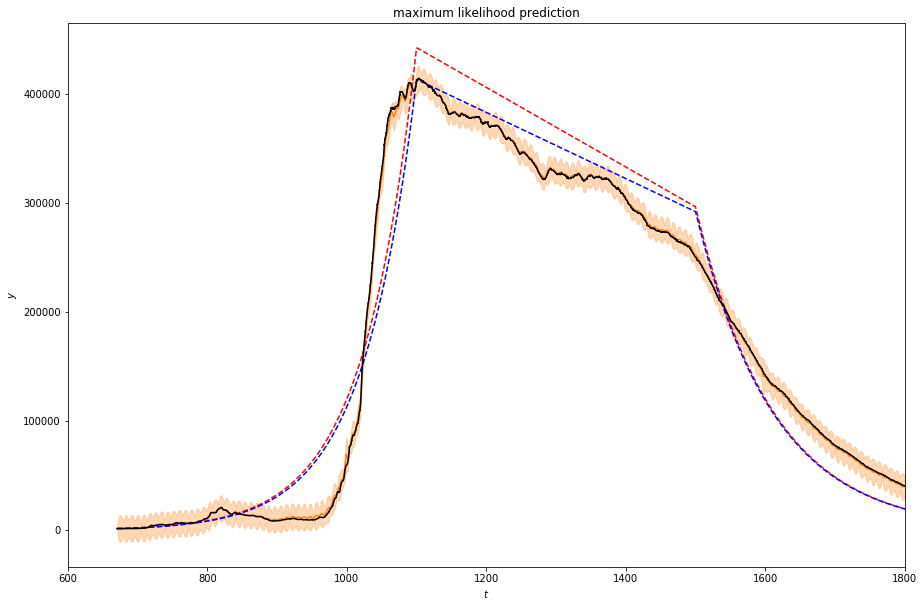

In [2]:
kernel = terms.RealTerm(log_a = np.log(A0), log_c = np.log(1./tau0))
gp = ce.GP(kernel, mean=TPW_Model, fit_mean=True)
gp.compute(x, yerr)

#L-BFGS-B likes when the order of magnitude is similar so we'll be using a scaling factor for optimization:
scalefac = np.array([1e-1, 1e1, 1e-3,1e-3,1e2,1e-2,1e3,1e-3])

#defining cost function:
def neg_log_like(sparams, y, gp):
    global scalefac
    params = sparams / scalefac
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(sparams, y, gp):
    global scalefac
    params = sparams / scalefac
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

#fitting
initial_params = gp.get_parameter_vector()
scaled_params = initial_params * scalefac
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, scaled_params, jac=grad_neg_log_like, method ="L-BFGS-B", bounds = bounds, args = (y, gp))
final_params = soln.x/scalefac
gp.set_parameter_vector(final_params)
print soln

#max prediction
t = np.linspace(x[0], x[-1:][0], 500)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)



#plot data
color = "#ff7f0e"
plt.figure(figsize = (15,10))
plt.errorbar(x, y, yerr=yerr, fmt="-k", capsize=0)
plt.plot(t, mu, color=color)
plt.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(600, 1800)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("maximum likelihood prediction")

#plot prediction
plt.plot(x, yinit, 'r--')
fpwmodel = PWModel(xl=final_params[2], xr=final_params[3], al=final_params[4], bl=final_params[5], ar=final_params[6], br=final_params[7])
ytest = fpwmodel.get_value(x)
plt.plot(x, ytest, 'b--')

plt.show()
